In [1]:
from yako_util import util as q
from yako_util import era5 as era5
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sklearn.metrics as metrics
import sklearn
from metpy.calc import mixing_ratio_from_specific_humidity, density
from metpy.units import units
from metpy.constants import g
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor
from torch.utils.data import DataLoader, TensorDataset
import torch
import random
from xgboost import XGBRegressor
from sklearn.cluster import KMeans
import optuna
import joblib

In [2]:
np.random.seed(132)
random.seed(132)

np.set_printoptions(suppress=True, precision=3)
torch.use_deterministic_algorithms(True)

## Load dataset

In [7]:
files = sorted(q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase'))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))
print(len(tc_sim_clear_files))

4128


In [8]:
files = sorted(q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase_delta'))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))
print(len(tc_sim_clear_files))

3445


In [3]:
files = sorted(q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase')) + sorted(q.list_files('/mnt/nas04/mykhailo/atlas_data_pmbase_delta'))

tc_gmi_files = sorted(list(filter(lambda x: 'gmi_tc' in x, files)))
tc_sim_scatt_files = sorted(list(filter(lambda x: 'Tc_hydro_13ch' in x, files)))
tc_sim_clear_files = sorted(list(filter(lambda x: 'Tc_clear_13ch' in x, files)))
es_files = sorted(list(filter(lambda x: 'es_telsem_13ch' in x, files)))
landsea_telsem_files = sorted(list(filter(lambda x: 'landsea_telsem' in x, files)))

specific_humidity_files = sorted(list(filter(lambda x: 'era5_specific_humidity' in x, files)))
temperature_files = sorted(list(filter(lambda x: 'era5_temperature' in x, files)))
surface_pressure_files = sorted(list(filter(lambda x: 'surface_pressure' in x, files)))
tm_temperature_files = sorted(list(filter(lambda x: 'era5_2m_temperature' in x, files)))
tm_dewpoint_temperature_files = sorted(list(filter(lambda x: 'era5_2m_dewpoint_temperature' in x, files)))
skin_temperature_files = sorted(list(filter(lambda x: 'era5_skin_temperature' in x, files)))

cloud_liquid_water_files = sorted(list(filter(lambda x: 'era5_cloud_liqud_water' in x, files)))
cloud_ice_water_files = sorted(list(filter(lambda x: 'era5_cloud_ice_water' in x, files)))
precip_liquid_water_files = sorted(list(filter(lambda x: 'era5_precip_liquid_water' in x, files)))
precip_ice_water_files = sorted(list(filter(lambda x: 'era5_precip_ice_water' in x, files)))

lat_files = sorted(list(filter(lambda x: 'gmi_lat' in x, files)))
lon_files = sorted(list(filter(lambda x: 'gmi_lon' in x, files)))

autosnow_files = sorted(list(filter(lambda x: 'autosnow' in x, files)))

In [23]:
tc_gmi = np.concatenate(list(map(np.load, tc_gmi_files)), axis=0)
tc_sim_scatt = np.concatenate(list(map(np.load, tc_sim_scatt_files)), axis=0)
tc_sim_clear = np.concatenate(list(map(np.load, tc_sim_clear_files)), axis=0)

lat = np.concatenate(list(map(np.load, lat_files)), axis=0)
lon = np.concatenate(list(map(np.load, lon_files)), axis=0)

pressure = np.tile(era5.get_pressure_levels()[::-1], (tc_gmi.shape[0], 1))
nprofiles = pressure.shape[0]
nlevels = pressure.shape[1]

surface_pressure = np.concatenate(list(map(np.load, surface_pressure_files)), axis=0).reshape(nprofiles)
tm_temperature = np.concatenate(list(map(np.load, tm_temperature_files)), axis=0).reshape(nprofiles)
tm_dewpoint_temperature = np.concatenate(list(map(np.load, tm_dewpoint_temperature_files)), axis=0).reshape(nprofiles)
skin_temperature = np.concatenate(list(map(np.load, skin_temperature_files)), axis=0).reshape(nprofiles)
autosnow = np.concatenate(list(map(np.load, autosnow_files)), axis=0).reshape(nprofiles)

specific_humidity = np.concatenate(list(map(np.load, specific_humidity_files)), axis=0).reshape(nprofiles, nlevels)
temperature = np.concatenate(list(map(np.load, temperature_files)), axis=0).reshape(nprofiles, nlevels)
cloud_liquid_water = np.concatenate(list(map(np.load, cloud_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
cloud_ice_water = np.concatenate(list(map(np.load, cloud_ice_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_liquid_water = np.concatenate(list(map(np.load, precip_liquid_water_files)), axis=0).reshape(nprofiles, nlevels)
precip_ice_water = np.concatenate(list(map(np.load, precip_ice_water_files)), axis=0).reshape(nprofiles, nlevels)

es = np.concatenate(list(map(np.load, es_files)), axis=0).reshape(nprofiles, 13)
landsea_telsem = np.concatenate(list(map(np.load, landsea_telsem_files)), axis=0).reshape(nprofiles)

In [24]:
mixing_ratio = mixing_ratio_from_specific_humidity(specific_humidity * units('kg/kg')).to('g/kg')
moist_air_density = density(pressure * units.hPa, temperature * units.K, mixing_ratio).to('kg/m3')

qr_avg = (precip_liquid_water[:,:-1] + precip_liquid_water[:,1:]) / 2
qi_avg = (precip_ice_water[:,:-1] + precip_ice_water[:,1:]) / 2
qc_avg = (cloud_liquid_water[:,:-1] + cloud_liquid_water[:,1:]) / 2
qci_avg = (cloud_ice_water[:,:-1] + cloud_ice_water[:,1:]) / 2

dp = -np.diff((pressure*units.hPa).to(units.Pa), axis=1)
tcwv = np.sum(((qr_avg + qi_avg + qc_avg + qci_avg) * dp) / g, axis=1).to('kg/m2').m

0 - water only \
1 - land only \
2 - snow land only \
3 - ice only \
4 - frozen sea (ice and water) \
5 - beach (land and water) \
6 - frozen beach (snow/land and water/ice) \
7 - glacier (snow/land and ice)

In [28]:
valid_mask = (
    np.all(tc_gmi >= 50, axis=1) &
    np.all(tc_gmi <= 500, axis=1) &
    np.all(tc_sim_scatt >= 50, axis=1) &
    np.all(tc_sim_scatt <= 500, axis=1) &
    np.all(tc_sim_clear >= 50, axis=1) &
    np.all(tc_sim_clear <= 500, axis=1)
)

telsem_surf = landsea_telsem == 1
telsem_water = landsea_telsem == 0

sea_mask = autosnow == 0
land_mask = autosnow == 1
snow_mask = autosnow == 2
ice_mask = autosnow == 3
frozen_sea_mask = autosnow == 4
beach_mask = (autosnow == 5) | (autosnow == 6)
glacier_mask = autosnow == 7

clear_sky_mask = tcwv <= 0.15

lat_mask = (lat >= 40) | (lat <= -40)

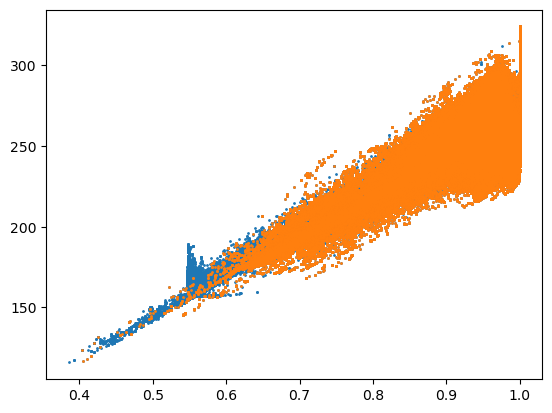

In [29]:
plt.scatter(es[valid_mask&lat_mask,0], tc_sim_scatt[valid_mask&lat_mask,0], s=1)
plt.scatter(es[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], tc_sim_scatt[valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask,0], s=1)
# plt.scatter(es[valid_mask&telsem_surf,0], tc_gmi[valid_mask&telsem_surf,0], s=1)
# plt.scatter(es[valid_mask&telsem_water,0], tc_gmi[valid_mask&telsem_water,0], s=1)

In [30]:
channels = q.gmi_channels()

# Direct models

In [31]:
features = np.array([
    *(tc_sim_scatt.T),
    # tcwv,
    surface_pressure,
    tm_dewpoint_temperature,
    tm_temperature,
    # skin_temperature,
    # autosnow,
]).T

labels = es[:,:]

feature_names = [
    *[f'Tc_{i}' for i in range(1, 14)],
    'surf pressure',
    't2m dewpoint temp',
    't2m temp',
    # 'skin temp',
    # 'autosnow',
]

In [32]:
# train_mask = np.array([True]*int(len(features)*split) + [False]*(len(features) - int(len(features)*split)))
train_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.7, 0.3])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)
# train_mask = np.random.rand(features.shape[0]) < 0.7
test_mask = ~train_mask

use_data_mask = valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask & clear_sky_mask
train_mask = train_mask & use_data_mask
test_mask = test_mask & use_data_mask

use_clear_sky_mask = clear_sky_mask[use_data_mask]

## Poly model

In [33]:
poly_features = PolynomialFeatures(degree=3)
X_train = poly_features.fit_transform(features[train_mask])
X_test = poly_features.transform(features[test_mask])
X = poly_features.transform(features[use_data_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [34]:
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [35]:
P_train = np.clip(lin_reg.predict(X_train), 0, 1)
P_test = np.clip(lin_reg.predict(X_test), 0, 1)
P = np.clip(lin_reg.predict(X), 0, 1)

In [36]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.003 0.004 0.004 0.004 0.004
 0.004]
[0.004 0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.005 0.006 0.006 0.006
 0.006]
[0.003 0.004 0.003 0.004 0.003 0.003 0.004 0.004 0.005 0.005 0.005 0.005
 0.005]
[0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.006 0.007 0.007 0.008 0.007
 0.007]


Text(0.5, 0.98, 'MAE - Poly')

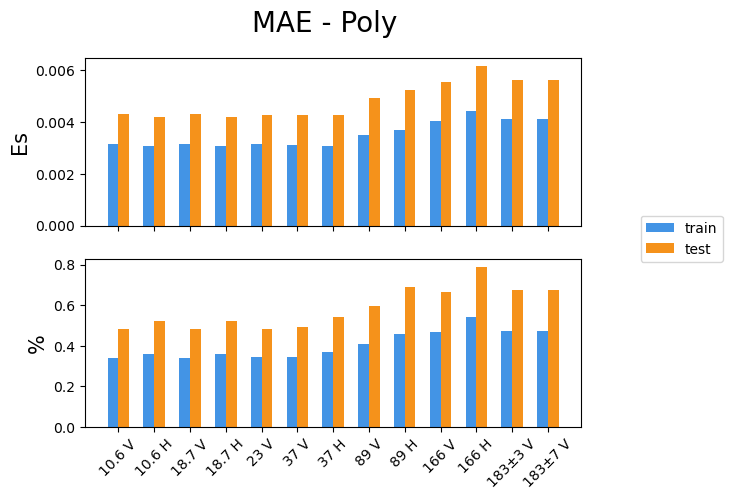

In [37]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - Poly', fontsize=20)

In [38]:
_lin_p_test = P_test

In [39]:
joblib.dump(lin_reg, 'poly.jlb')

['poly.jlb']

## XGBOOST

In [40]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [41]:
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=132,
)

xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=132, ...)

In [42]:
P_train = np.clip(xgb_reg.predict(X_train), 0, 1)
P_test = np.clip(xgb_reg.predict(X_test), 0, 1)
P = np.clip(xgb_reg.predict(X), 0, 1)

In [43]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.003 0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.006 0.005 0.006 0.005
 0.005]
[0.007 0.007 0.007 0.007 0.007 0.008 0.008 0.009 0.01  0.01  0.011 0.01
 0.01 ]
[0.004 0.004 0.004 0.004 0.004 0.004 0.005 0.006 0.007 0.006 0.007 0.006
 0.006]
[0.008 0.008 0.008 0.008 0.008 0.009 0.01  0.011 0.014 0.012 0.014 0.012
 0.012]


Text(0.5, 0.98, 'MAE - GBRT')

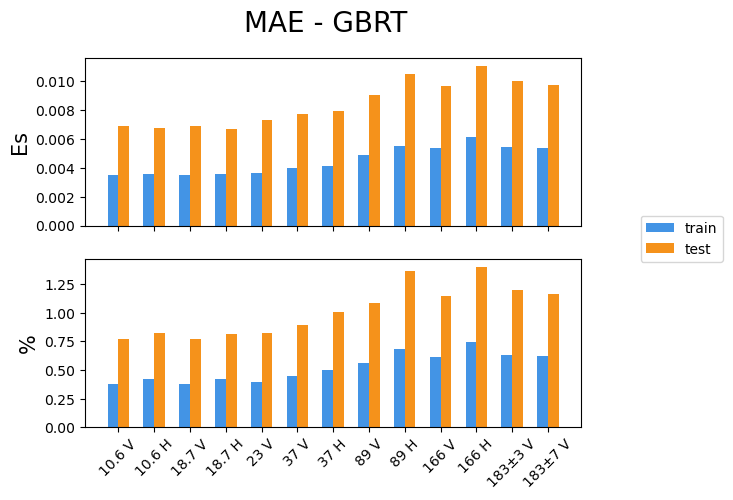

In [44]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [45]:
_xgb_p_test = P_test

In [46]:
joblib.dump(xgb_reg, 'xgb.jlb')

['xgb.jlb']

## GBRT model

In [47]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [48]:
gbrt_reg = MultiOutputRegressor(HistGradientBoostingRegressor(verbose=1))
gbrt_reg.fit(X_train, Y_train)

Binning 0.018 GB of training data: 0.219 s
Binning 0.002 GB of validation data: 0.002 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.00219, val loss: 0.00220, in 0.013s
[2/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00180, val loss: 0.00181, in 0.006s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00149, val loss: 0.00150, in 0.006s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.00123, val loss: 0.00124, in 0.006s
[5/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00102, val loss: 0.00103, in 0.006s
[6/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00085, val loss: 0.00086, in 0.006s
[7/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00071, val loss: 0.00072, in 0.006s
[8/100] 1 tree, 31 leaves, max depth = 7, train loss: 0.00060, val loss: 0.00060, in 0.006s
[9/100] 1 tree, 31 leaves, max depth = 8, train loss: 0.00050, val loss: 0.00051, in 0.006s
[10/100] 1 tree, 31 leaves, max depth = 7, train lo

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(verbose=1))

In [49]:
# sorted(list(zip(gbrt_reg.estimators_[0].feature_importances_, feature_names)), reverse=True)

In [50]:
P_train = np.clip(gbrt_reg.predict(X_train), 0, 1)
P_test = np.clip(gbrt_reg.predict(X_test), 0, 1)
P = np.clip(gbrt_reg.predict(X), 0, 1)

In [51]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.006 0.006 0.006 0.006 0.006 0.006 0.007 0.008 0.009 0.008 0.01  0.008
 0.008]
[0.007 0.008 0.008 0.007 0.008 0.009 0.009 0.01  0.011 0.011 0.012 0.011
 0.011]
[0.006 0.007 0.006 0.007 0.006 0.007 0.008 0.009 0.011 0.01  0.012 0.01
 0.01 ]
[0.008 0.009 0.008 0.009 0.009 0.01  0.011 0.012 0.015 0.012 0.016 0.012
 0.012]


Text(0.5, 0.98, 'MAE - GBRT')

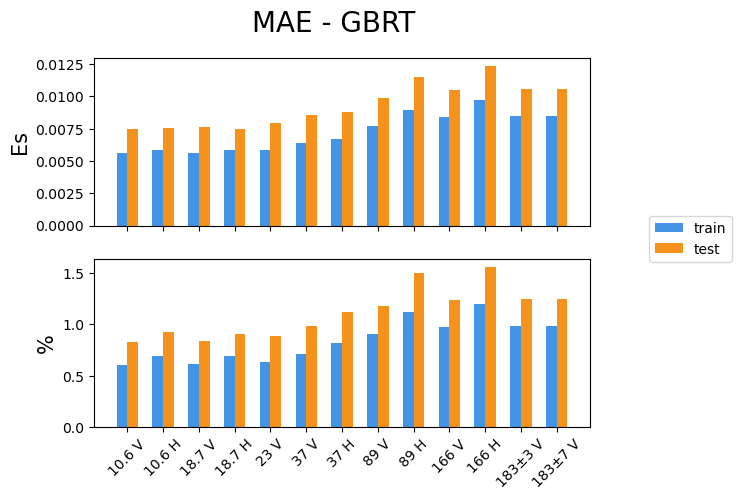

In [52]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [53]:
_gbrt_p_test = P_test

In [54]:
joblib.dump(gbrt_reg, 'gbrt.jlb')

['gbrt.jlb']

## NN model

In [75]:
val_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.3, 0.7])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)

X_train = features[train_mask&(~val_mask)]
X_test = features[test_mask]
X_val = features[train_mask&(val_mask)]
X = features[use_data_mask]

Y_train = labels[train_mask&(~val_mask)]
Y_test = labels[test_mask]
Y_val = labels[train_mask&(val_mask)]
Y = labels[use_data_mask]

In [76]:
min_max = np.array([
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [50, 400],
    [40000, 150000],
    [200, 350],
    [200, 350],
    # [0, 7],
    # [0, 0.25],
])

X_train_norm = (X_train - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_test_norm = (X_test - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_val_norm = (X_val - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
X_norm = (X - min_max[:,0]) / (min_max[:,1] - min_max[:,0]) - 0.5
# X_train_norm = (X_train - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_test_norm = (X_test - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_val_norm = (X_val - X_train.mean(axis=0)) / (X_train.std(axis=0))
# X_norm = (X - X_train.mean(axis=0)) / (X_train.std(axis=0))

Y_train_norm = np.clip(2*(Y_train - 0.5), 0, 1)
Y_test_norm = np.clip(2*(Y_test - 0.5), 0, 1)
Y_val_norm = np.clip(2*(Y_val - 0.5), 0, 1)
Y_norm = np.clip(2*(Y - 0.5), 0, 1)

train_loader = DataLoader(TensorDataset(torch.Tensor(X_train_norm), torch.Tensor(Y_train_norm)), batch_size=256, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.Tensor(X_test_norm), torch.Tensor(Y_test_norm)), batch_size=256)
val_loader = DataLoader(TensorDataset(torch.Tensor(X_val_norm), torch.Tensor(Y_val_norm)), batch_size=256)

In [77]:
import direct
from importlib import reload
reload(direct)

study = optuna.create_study(direction='minimize')
study.optimize(direct.objective(train_loader, val_loader), n_trials=10)

model = direct.optuna_best(study, train_loader, val_loader)

# early_stopper = direct.EarlyStopping(patience=10)
# trainer = direct.ModelTrainer(model, early_stopper=early_stopper, lr=0.001)

# trainer.train(train_loader, val_loader, epochs=1000)
# trainer.test(test_loader)

[I 2025-01-06 11:55:41,797] A new study created in memory with name: no-name-c92d39dd-3774-46b2-80ff-a358b2edae51


Epoch 1/1000, Train Loss: 0.1353, Val Loss: 0.1338
Epoch 2/1000, Train Loss: 0.1349, Val Loss: 0.1289
Epoch 3/1000, Train Loss: 0.1303, Val Loss: 0.1247
Epoch 4/1000, Train Loss: 0.1262, Val Loss: 0.1208
Epoch 5/1000, Train Loss: 0.1224, Val Loss: 0.1173
Epoch 6/1000, Train Loss: 0.1189, Val Loss: 0.1140
Epoch 7/1000, Train Loss: 0.1156, Val Loss: 0.1109
Epoch 8/1000, Train Loss: 0.1125, Val Loss: 0.1081
Epoch 9/1000, Train Loss: 0.1097, Val Loss: 0.1054
Epoch 10/1000, Train Loss: 0.1070, Val Loss: 0.1029
Epoch 11/1000, Train Loss: 0.1045, Val Loss: 0.1006
Epoch 12/1000, Train Loss: 0.1022, Val Loss: 0.0985
Epoch 13/1000, Train Loss: 0.1000, Val Loss: 0.0966
Epoch 14/1000, Train Loss: 0.0981, Val Loss: 0.0948
Epoch 15/1000, Train Loss: 0.0962, Val Loss: 0.0932
Epoch 16/1000, Train Loss: 0.0946, Val Loss: 0.0917
Epoch 17/1000, Train Loss: 0.0931, Val Loss: 0.0904
Epoch 18/1000, Train Loss: 0.0918, Val Loss: 0.0892
Epoch 19/1000, Train Loss: 0.0906, Val Loss: 0.0882
Epoch 20/1000, Train 

[I 2025-01-06 14:00:51,996] Trial 0 finished with value: 0.08207132085961731 and parameters: {'n_layers': 1, 'n_units': 121, 'dropout_rate': 0.2582067655258963, 'learning_rate': 0.00011606824139725299}. Best is trial 0 with value: 0.08207132085961731.


Epoch 1/1000, Train Loss: 0.1413, Val Loss: 0.1295
Epoch 2/1000, Train Loss: 0.1288, Val Loss: 0.1220
Epoch 3/1000, Train Loss: 0.1216, Val Loss: 0.1155
Epoch 4/1000, Train Loss: 0.1154, Val Loss: 0.1098
Epoch 5/1000, Train Loss: 0.1100, Val Loss: 0.1049
Epoch 6/1000, Train Loss: 0.1052, Val Loss: 0.1006
Epoch 7/1000, Train Loss: 0.1012, Val Loss: 0.0970
Epoch 8/1000, Train Loss: 0.0977, Val Loss: 0.0940
Epoch 9/1000, Train Loss: 0.0948, Val Loss: 0.0914
Epoch 10/1000, Train Loss: 0.0923, Val Loss: 0.0892
Epoch 11/1000, Train Loss: 0.0902, Val Loss: 0.0875
Epoch 12/1000, Train Loss: 0.0885, Val Loss: 0.0861
Epoch 13/1000, Train Loss: 0.0871, Val Loss: 0.0849
Epoch 14/1000, Train Loss: 0.0861, Val Loss: 0.0840
Epoch 15/1000, Train Loss: 0.0852, Val Loss: 0.0833
Epoch 16/1000, Train Loss: 0.0845, Val Loss: 0.0828
Epoch 17/1000, Train Loss: 0.0839, Val Loss: 0.0825
Epoch 18/1000, Train Loss: 0.0836, Val Loss: 0.0822
Epoch 19/1000, Train Loss: 0.0833, Val Loss: 0.0820
Epoch 20/1000, Train 

[I 2025-01-06 14:12:59,118] Trial 1 finished with value: 0.08190336703862014 and parameters: {'n_layers': 2, 'n_units': 43, 'dropout_rate': 0.284739023134265, 'learning_rate': 0.000179472533287427}. Best is trial 1 with value: 0.08190336703862014.


Epoch 1/1000, Train Loss: 0.1168, Val Loss: 0.0897
Epoch 2/1000, Train Loss: 0.0865, Val Loss: 0.0825
Epoch 3/1000, Train Loss: 0.0831, Val Loss: 0.0819
Epoch 4/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 5/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 6/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 7/1000, Train Loss: 0.0827, Val Loss: 0.0820
Epoch 8/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 9/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 10/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 11/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 12/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 13/1000, Train Loss: 0.0828, Val Loss: 0.0819
Early stopping at epoch 13


[I 2025-01-06 14:24:22,200] Trial 2 finished with value: 0.08188392647395008 and parameters: {'n_layers': 3, 'n_units': 103, 'dropout_rate': 0.44522780706098086, 'learning_rate': 0.0024349236587923795}. Best is trial 2 with value: 0.08188392647395008.


Epoch 1/1000, Train Loss: 0.1463, Val Loss: 0.1330
Epoch 2/1000, Train Loss: 0.1281, Val Loss: 0.1184
Epoch 3/1000, Train Loss: 0.1122, Val Loss: 0.1013
Epoch 4/1000, Train Loss: 0.0955, Val Loss: 0.0885
Epoch 5/1000, Train Loss: 0.0865, Val Loss: 0.0835
Epoch 6/1000, Train Loss: 0.0836, Val Loss: 0.0821
Epoch 7/1000, Train Loss: 0.0829, Val Loss: 0.0819
Epoch 8/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 9/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 10/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 11/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 12/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 13/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 14/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 15/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 16/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 17/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 18/1000, Train Loss: 0.0827, Val Loss: 0.0819
Early stopping at epoch 18


[I 2025-01-06 14:34:07,656] Trial 3 finished with value: 0.0819320139034014 and parameters: {'n_layers': 1, 'n_units': 67, 'dropout_rate': 0.43016482986592386, 'learning_rate': 0.0003295459241465706}. Best is trial 2 with value: 0.08188392647395008.


Epoch 1/1000, Train Loss: 0.1208, Val Loss: 0.1117
Epoch 2/1000, Train Loss: 0.0932, Val Loss: 0.0859
Epoch 3/1000, Train Loss: 0.0853, Val Loss: 0.0824
Epoch 4/1000, Train Loss: 0.0830, Val Loss: 0.0819
Epoch 5/1000, Train Loss: 0.0828, Val Loss: 0.0818
Epoch 6/1000, Train Loss: 0.0827, Val Loss: 0.0820
Epoch 7/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 8/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 9/1000, Train Loss: 0.0827, Val Loss: 0.0820
Epoch 10/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 11/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 12/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 13/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 14/1000, Train Loss: 0.0827, Val Loss: 0.0820
Epoch 15/1000, Train Loss: 0.0827, Val Loss: 0.0819
Early stopping at epoch 15


[I 2025-01-06 14:44:18,441] Trial 4 finished with value: 0.08191789570019434 and parameters: {'n_layers': 5, 'n_units': 79, 'dropout_rate': 0.10551643914838996, 'learning_rate': 0.00015279545194657942}. Best is trial 2 with value: 0.08188392647395008.


Epoch 1/1000, Train Loss: 0.0968, Val Loss: 0.0823
Epoch 2/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 3/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 4/1000, Train Loss: 0.0827, Val Loss: 0.0818
Epoch 5/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 6/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 7/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 8/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 9/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 10/1000, Train Loss: 0.0828, Val Loss: 0.0819
Epoch 11/1000, Train Loss: 0.0827, Val Loss: 0.0820
Epoch 12/1000, Train Loss: 0.0827, Val Loss: 0.0819
Epoch 13/1000, Train Loss: 0.0828, Val Loss: 0.0820
Epoch 14/1000, Train Loss: 0.0828, Val Loss: 0.0819
Early stopping at epoch 14


[I 2025-01-06 14:56:15,821] Trial 5 finished with value: 0.08190839446492885 and parameters: {'n_layers': 3, 'n_units': 101, 'dropout_rate': 0.25324539226696624, 'learning_rate': 0.0033759477118142263}. Best is trial 2 with value: 0.08188392647395008.


Epoch 1/1000, Train Loss: 0.1274, Val Loss: 0.1179
Epoch 2/1000, Train Loss: 0.0937, Val Loss: 0.0850
Epoch 3/1000, Train Loss: 0.0839, Val Loss: 0.0822
Epoch 4/1000, Train Loss: 0.0829, Val Loss: 0.0819


[W 2025-01-06 15:00:42,288] Trial 6 failed with parameters: {'n_layers': 3, 'n_units': 119, 'dropout_rate': 0.3192333826500353, 'learning_rate': 0.00024646736263024874} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mykhailo/micromamba/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/home/mykhailo/gen_atlas/model/direct.py", line 18, in search
    trainer.train(train_loader, val_loader, epochs=1000)
  File "/home/mykhailo/gen_atlas/model/direct.py", line 76, in train
    self.optimizer.step()
  File "/home/mykhailo/micromamba/lib/python3.9/site-packages/torch/optim/lr_scheduler.py", line 137, in wrapper
    return func.__get__(opt, opt.__class__)(*args, **kwargs)
  File "/home/mykhailo/micromamba/lib/python3.9/site-packages/torch/optim/optimizer.py", line 487, in wrapper
    out = func(*args, **kwargs)
  File "/home/mykhailo/micromamba/lib/python3.9/site-pack

KeyboardInterrupt: 

In [93]:
with torch.no_grad():
    P_train = np.clip(model(torch.Tensor(X_train_norm)).numpy()/2+0.5, 0, 1)
    P_test = np.clip(model(torch.Tensor(X_test_norm)).numpy()/2+0.5, 0, 1)
    P = np.clip(model(torch.Tensor(X_norm)).numpy()/2+0.5, 0, 1)

In [94]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[0.004 0.009 0.004 0.009 0.004 0.006 0.01  0.009 0.013 0.009 0.012 0.009
 0.009]
[0.006 0.011 0.006 0.011 0.006 0.008 0.012 0.012 0.016 0.012 0.015 0.012
 0.012]
[0.005 0.021 0.005 0.021 0.005 0.007 0.018 0.012 0.02  0.012 0.018 0.012
 0.012]
[0.007 0.024 0.007 0.024 0.007 0.011 0.021 0.016 0.026 0.016 0.022 0.016
 0.016]


Text(0.5, 0.98, 'MAE - NN')

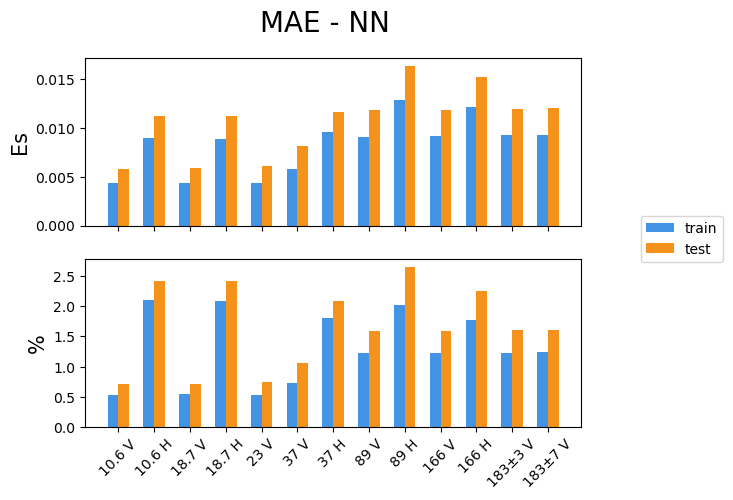

In [95]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - NN', fontsize=20)

In [96]:
_nn_p_test = P_test

In [ ]:
joblib.dump(model, 'nn.jlb')

## Unsupervised

In [97]:
val_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.3, 0.7])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)

X_train = features[train_mask&(~val_mask)]
X_test = features[test_mask]
X_val = features[train_mask&(val_mask)]
X = features[use_data_mask]

Y_train = labels[train_mask&(~val_mask)]
Y_test = labels[test_mask]
Y_val = labels[train_mask&(val_mask)]
Y = labels[use_data_mask]

In [98]:
kmeans = KMeans(n_clusters=3, random_state=132)
p_train = kmeans.fit_predict(X_train)

kmean_es = KMeans(n_clusters=3, random_state=132)
p_train_es = kmean_es.fit_predict(Y_train)

In [99]:
p = kmeans.predict(X)
p_es = kmean_es.predict(Y)

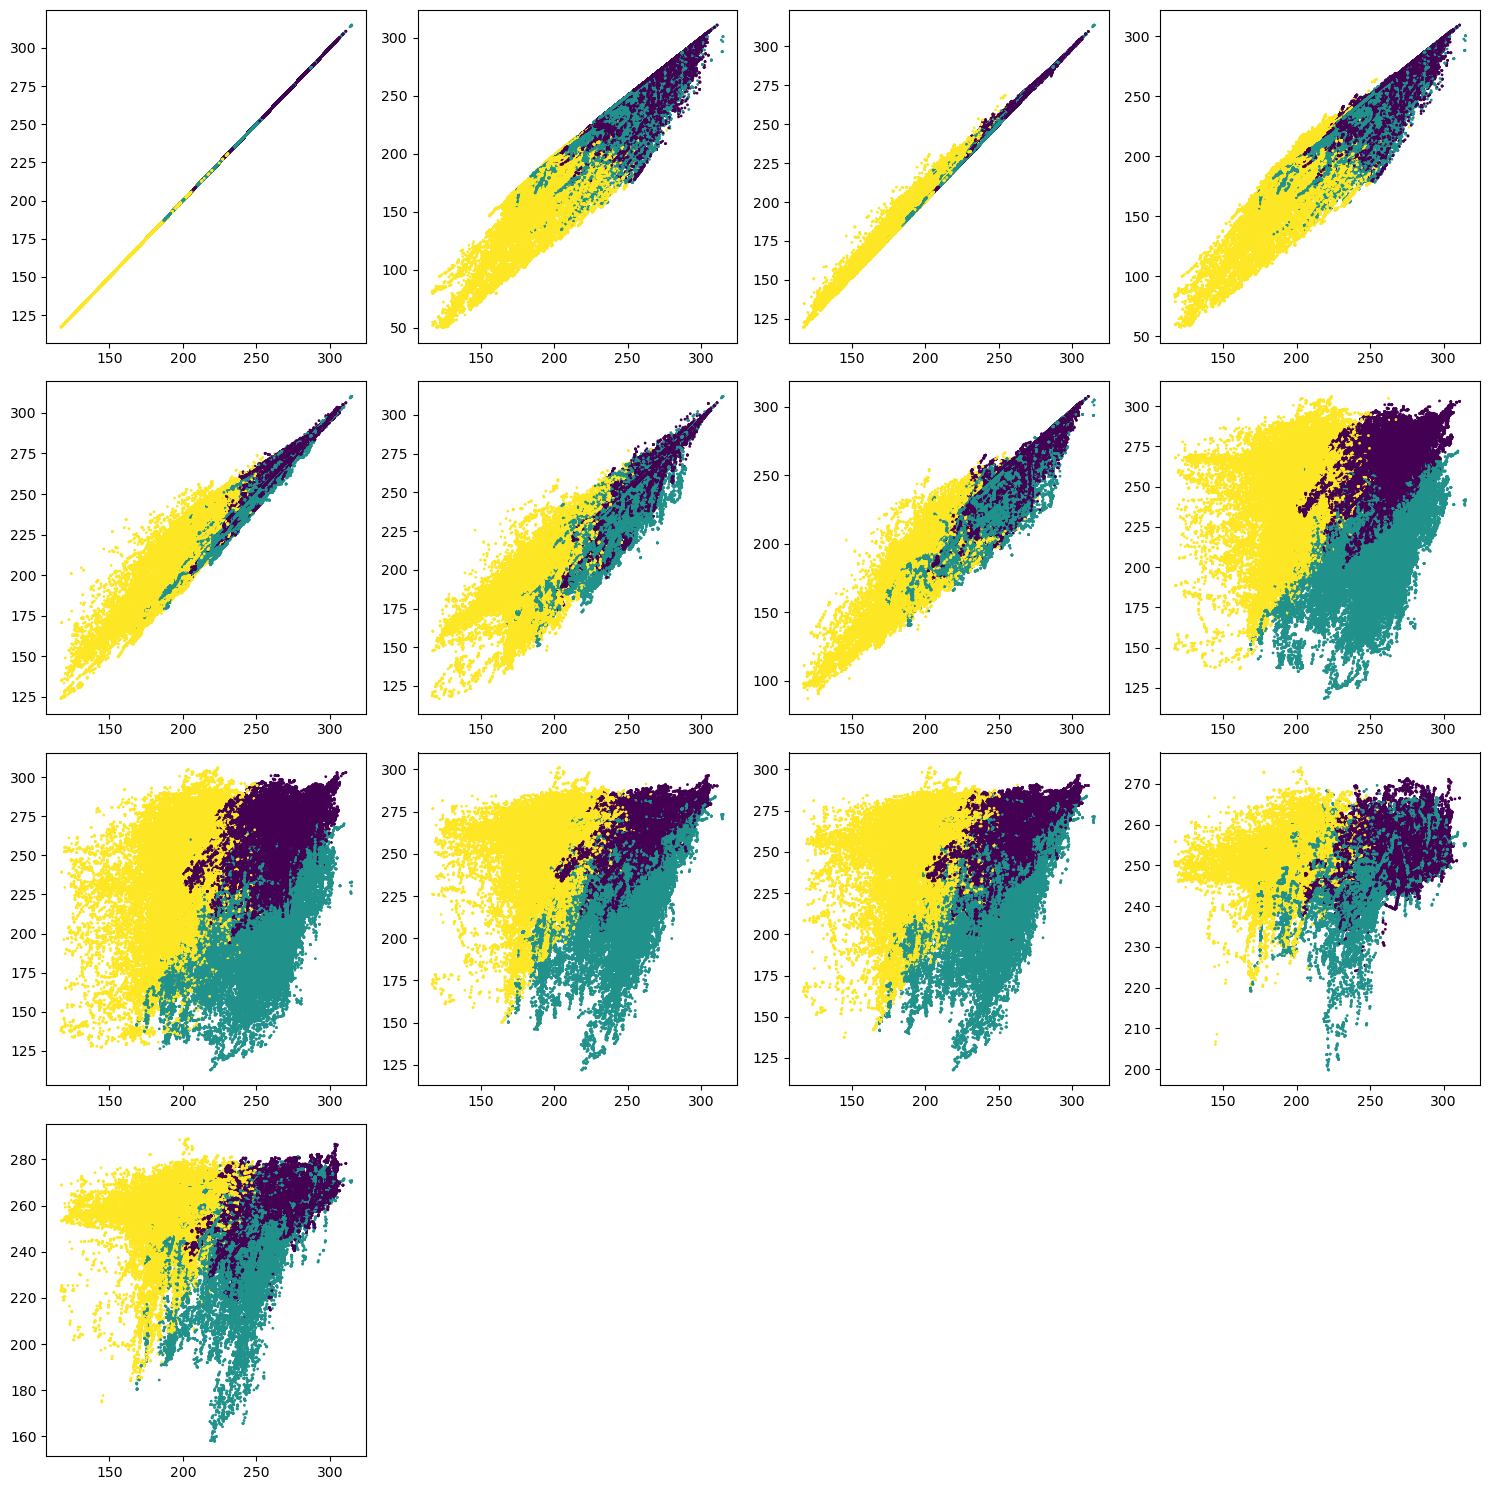

In [100]:
plt.figure(figsize=(15, 15))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    plt.scatter(X[:,0], X[:,chan], s=1, c=p_es)
plt.tight_layout()

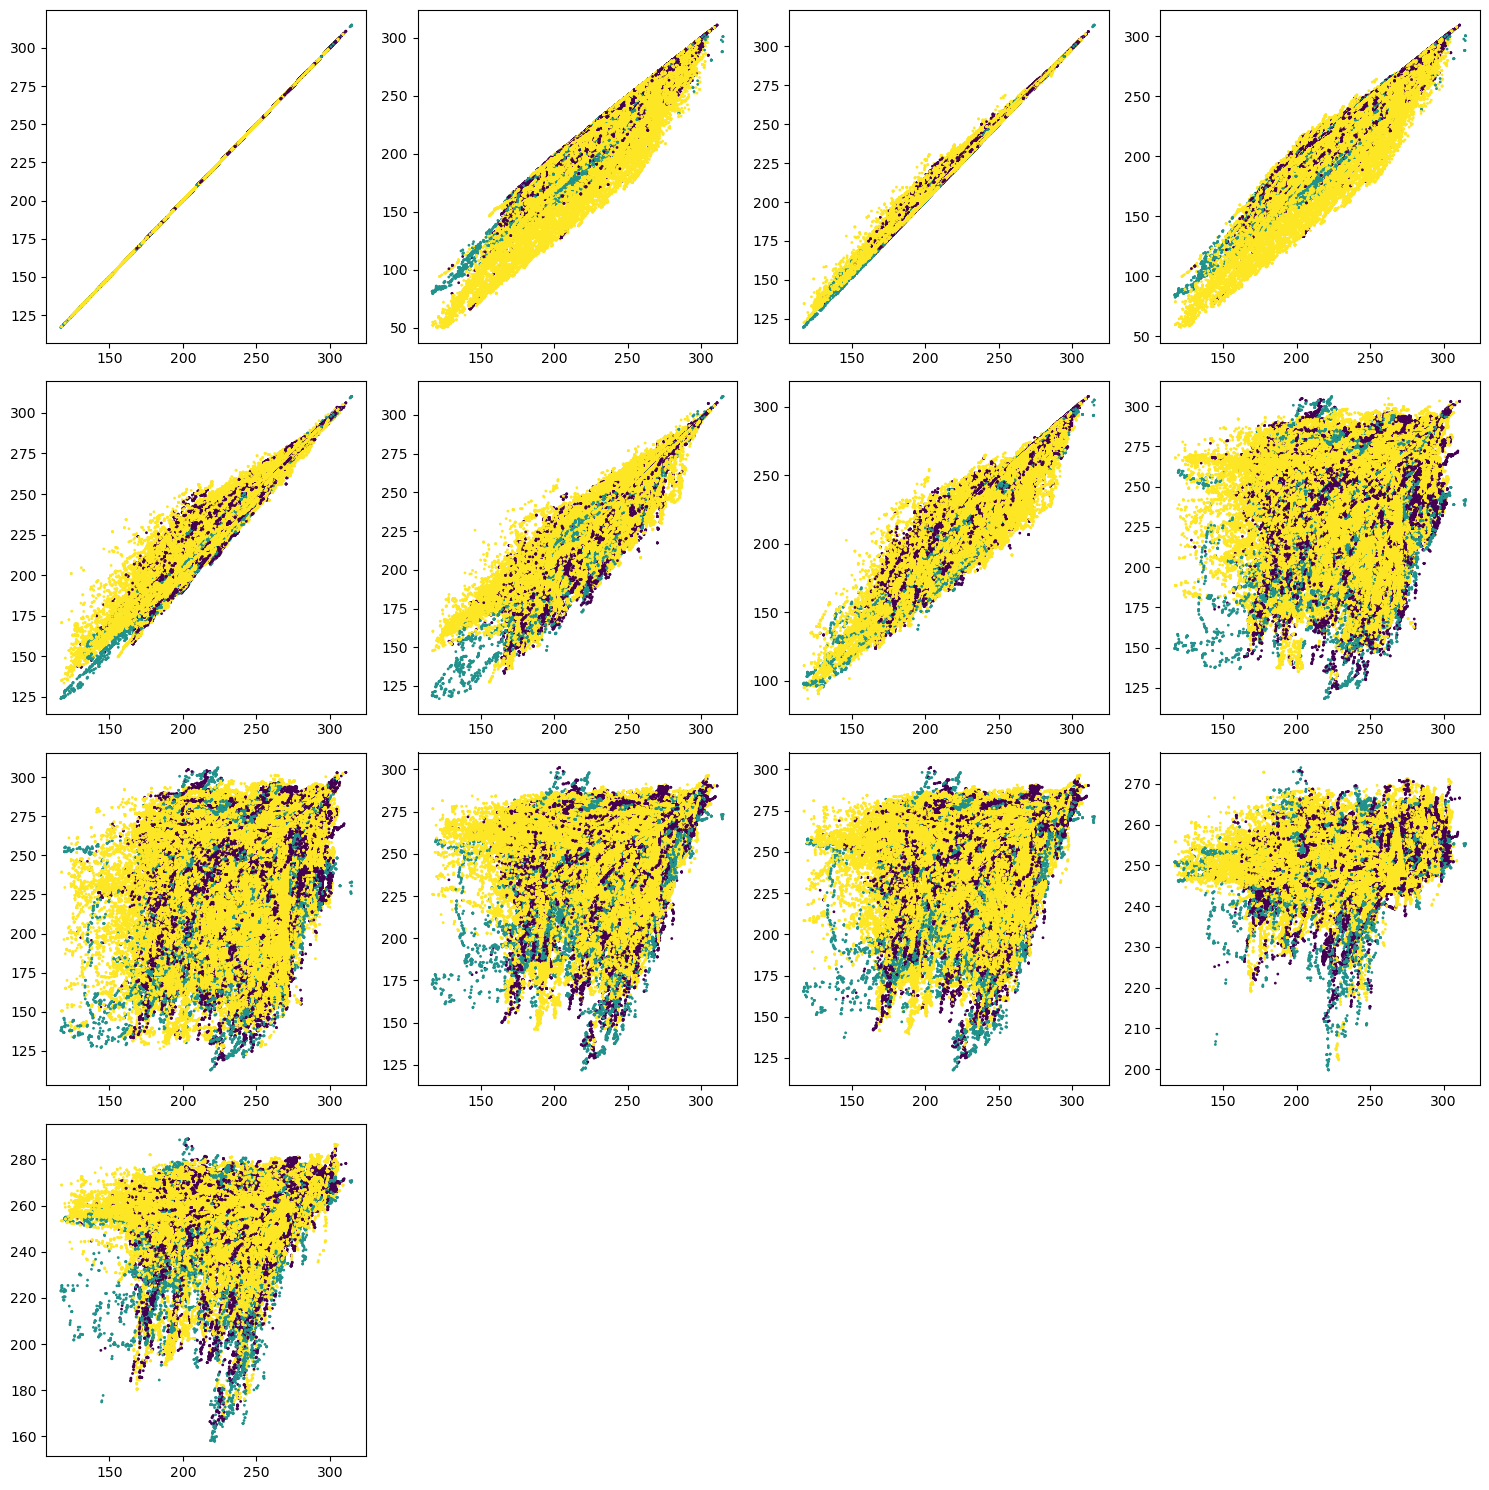

In [101]:
plt.figure(figsize=(15, 15))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    plt.scatter(X[:,0], X[:,chan], s=1, c=p)
plt.tight_layout()

## Post analysis

/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


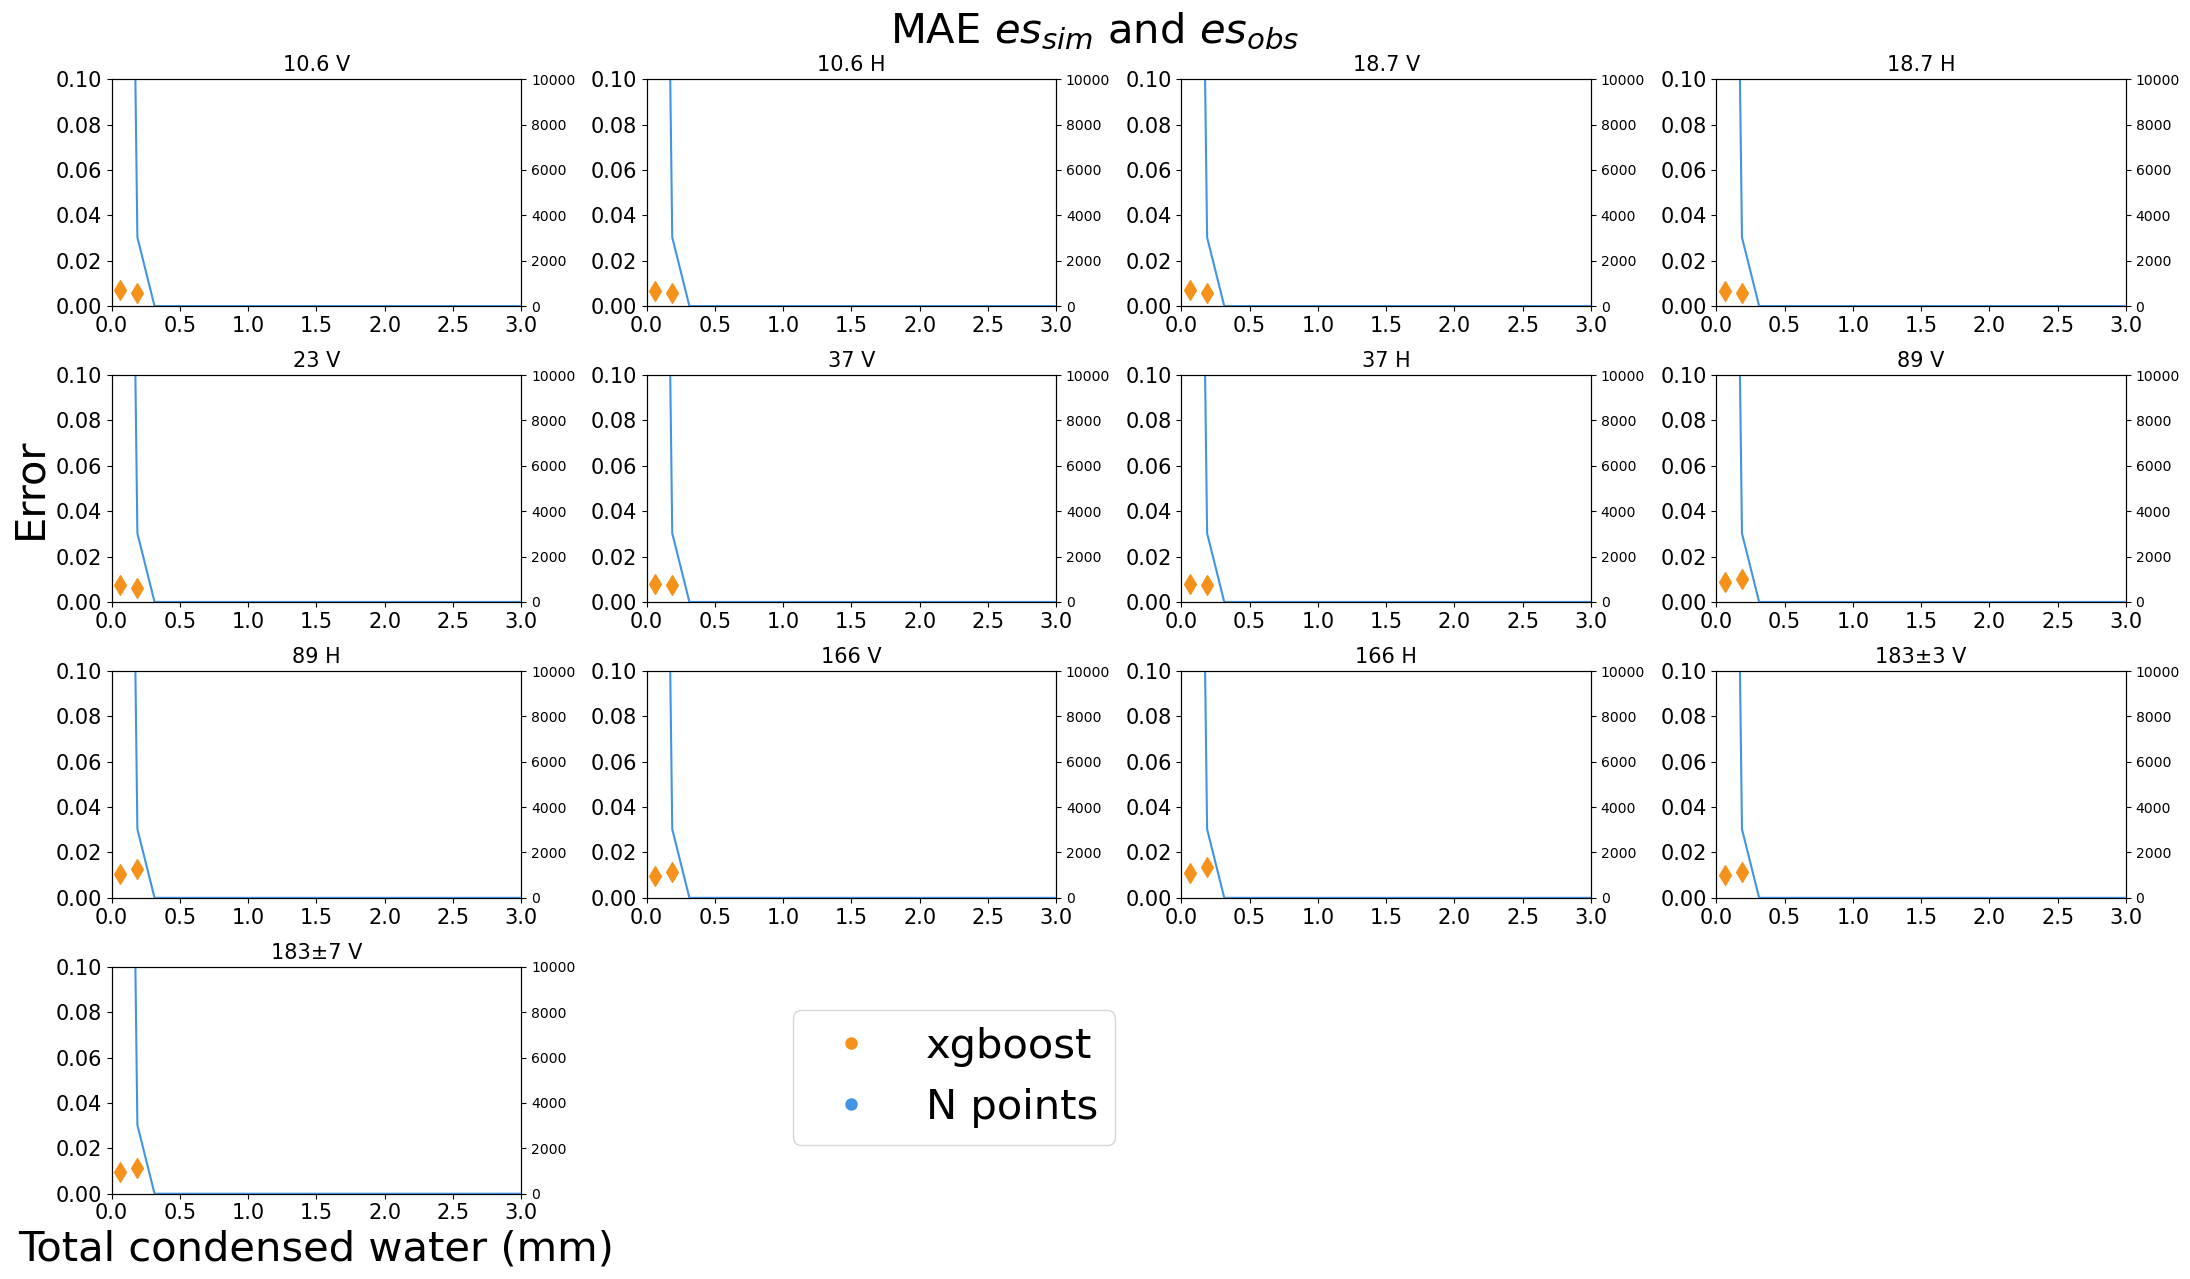

In [55]:
use_mask = land_mask | snow_mask | ice_mask

nbins = 100

bins = np.linspace(tcwv[use_mask].min(), tcwv[use_mask].max(), nbins+1)

error_xgboost = _xgb_p_test - Y_test

bin_indices = np.digitize(tcwv[use_data_mask&test_mask], bins) - 1

plt.figure(figsize=(22, 13))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    avg_errors_xgboost = []
    nsamples = []

    for i in range(nbins):
        bin_mask = bin_indices == i
        
        avg_errors_xgboost.append(np.mean(np.abs(error_xgboost[bin_mask,chan])))
        nsamples.append(len(error_xgboost[bin_mask,chan]))

    avg_errors_xgboost = np.array(avg_errors_xgboost)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.scatter(bin_centers, avg_errors_xgboost, c='#F5921B', marker='d', label='xgboost', s=100)

    if chan == 12:
        plt.xlabel('Total condensed water (mm)', fontsize=30)
    if chan == 4:
        plt.ylabel('Error', fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.title(channels[chan], fontsize=15)
    plt.xlim(0, 3)
    plt.ylim(0, 0.1)

    ax2 = plt.gca().twinx()
    ax2.plot(bin_centers, nsamples, c='#4394E5')
    ax2.set_ylim(0, 10000)

plt.suptitle('MAE $es_{sim}$ and $es_{obs}$', fontsize=30)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='xgboost'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='N points'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=30)

In [57]:
lin_err = (metrics.mean_absolute_error(Y_test, _lin_p_test, multioutput='raw_values'))
grbt_err = (metrics.mean_absolute_error(Y_test, _gbrt_p_test, multioutput='raw_values'))
# nn_err = (metrics.mean_absolute_error(Y_test, _nn_p_test, multioutput='raw_values'))
xgb_err = (metrics.mean_absolute_error(Y_test, _xgb_p_test, multioutput='raw_values'))
nn_err = xgb_err

for i in range(len(channels)):
    print(f'{channels[i]:8s} {lin_err[i]:.3f} {grbt_err[i]:.3f} {nn_err[i]:.3f} {xgb_err[i]:.3f}')

10.6 V   0.004 0.007 0.007 0.007
10.6 H   0.004 0.008 0.007 0.007
18.7 V   0.004 0.008 0.007 0.007
18.7 H   0.004 0.007 0.007 0.007
23 V     0.004 0.008 0.007 0.007
37 V     0.004 0.009 0.008 0.008
37 H     0.004 0.009 0.008 0.008
89 V     0.005 0.010 0.009 0.009
89 H     0.005 0.011 0.010 0.010
166 V    0.006 0.011 0.010 0.010
166 H    0.006 0.012 0.011 0.011
183±3 V  0.006 0.011 0.010 0.010
183±7 V  0.006 0.011 0.010 0.010


# Inverse models

In [74]:
features = np.array([
    *(es.T),
    surface_pressure,
    tm_dewpoint_temperature,
    tm_temperature,
]).T

labels = np.array([
    *(tc_sim_scatt.T),
]).T


feature_names = [
    *[f'es_{i}' for i in range(1, 14)],
    'surf pressure',
    't2m dewpoint temp',
    't2m temp',
]

In [75]:
train_mask = np.concatenate([np.full(size, np.random.choice([True, False], p=[0.7, 0.3])) for size in list(map(lambda x: len(x), map(np.load, autosnow_files)))], axis=0)
test_mask = ~train_mask

use_data_mask = valid_mask&(land_mask|snow_mask|ice_mask)&telsem_surf&lat_mask & clear_sky_mask
train_mask = train_mask & use_data_mask
test_mask = test_mask & use_data_mask

use_clear_sky_mask = clear_sky_mask[use_data_mask]

## XGBOOST

In [124]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [125]:
xgb_reg = XGBRegressor(
    objective='reg:squarederror',
    max_depth=7,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=132,
)

xgb_reg.fit(X_train, Y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=132, ...)

In [126]:
P_train = xgb_reg.predict(X_train)
P_test = xgb_reg.predict(X_test)
P = xgb_reg.predict(X)

In [127]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[1.534 1.519 1.507 1.502 1.478 1.46  1.497 1.574 1.768 1.768 2.091 1.944
 1.875]
[2.941 2.878 2.889 2.856 2.795 2.756 2.724 2.809 3.164 3.11  3.599 3.173
 3.092]
[0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.008 0.007 0.009 0.008
 0.007]
[0.011 0.012 0.011 0.012 0.011 0.011 0.012 0.011 0.014 0.013 0.015 0.013
 0.012]


Text(0.5, 0.98, 'MAE - XGBoost')

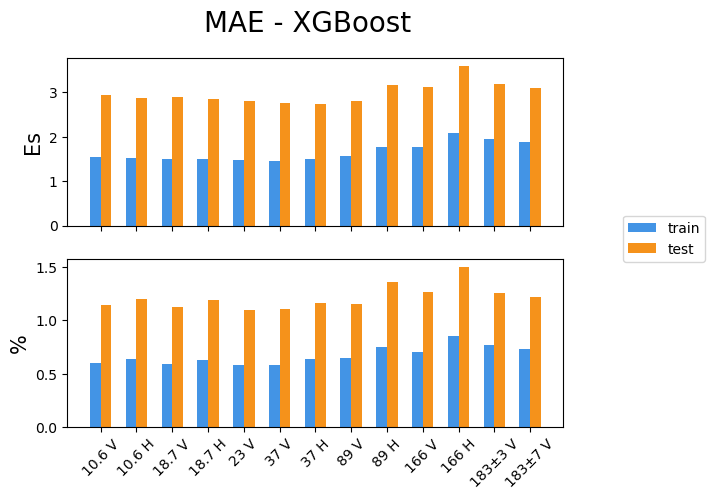

In [128]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - XGBoost', fontsize=20)

In [129]:
_xgb_p_test = P_test

In [130]:
joblib.dump(xgb_reg, 'xgb_direct.jlb')

['xgb_direct.jlb']

## Poly model

In [131]:
poly_features = PolynomialFeatures(degree=3)
X_train = poly_features.fit_transform(features[train_mask])
X_test = poly_features.transform(features[test_mask])
X = poly_features.transform(features[use_data_mask])

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [132]:
lin_reg = MultiOutputRegressor(LinearRegression())
lin_reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [133]:
P_train = lin_reg.predict(X_train)
P_test = lin_reg.predict(X_test)
P = lin_reg.predict(X)

In [134]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[3.001 2.888 3.076 3.055 3.301 2.927 2.991 2.962 3.357 3.333 4.027 3.136
 3.436]
[3.315 3.194 3.39  3.368 3.602 3.213 3.278 3.249 3.663 3.499 4.242 3.318
 3.597]
[0.012 0.012 0.012 0.013 0.013 0.012 0.013 0.012 0.014 0.014 0.017 0.012
 0.014]
[0.013 0.013 0.013 0.014 0.014 0.013 0.014 0.013 0.016 0.014 0.018 0.013
 0.014]


Text(0.5, 0.98, 'MAE - Poly')

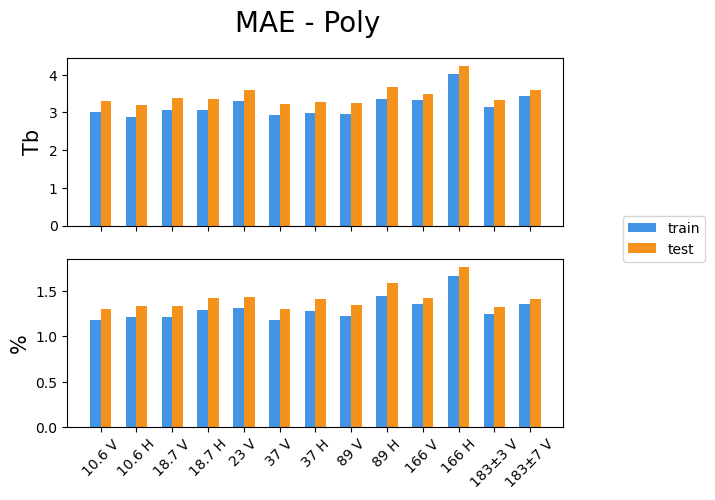

In [135]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Tb', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - Poly', fontsize=20)

In [136]:
_lin_p_test = P_test

In [137]:
joblib.dump(lin_reg, 'poly_direct.jlb')

['poly_direct.jlb']

## GBRT model

In [103]:
X_train = features[train_mask]
X_test = features[test_mask]
X = features[use_data_mask]

Y_train = labels[train_mask]
Y_test = labels[test_mask]
Y = labels[use_data_mask]

In [106]:
gbrt_reg = MultiOutputRegressor(HistGradientBoostingRegressor(verbose=1))
gbrt_reg.fit(X_train, Y_train)

Binning 0.018 GB of training data: 

0.219 s
Binning 0.002 GB of validation data: 0.001 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 7, train loss: 214.02381, val loss: 213.40479, in 0.007s
[2/100] 1 tree, 31 leaves, max depth = 7, train loss: 176.79696, val loss: 176.13138, in 0.006s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 146.25438, val loss: 145.72504, in 0.006s
[4/100] 1 tree, 31 leaves, max depth = 7, train loss: 121.47297, val loss: 121.06905, in 0.006s
[5/100] 1 tree, 31 leaves, max depth = 6, train loss: 101.16187, val loss: 100.80669, in 0.006s
[6/100] 1 tree, 31 leaves, max depth = 7, train loss: 84.44884, val loss: 84.17234, in 0.006s
[7/100] 1 tree, 31 leaves, max depth = 7, train loss: 70.79602, val loss: 70.57490, in 0.006s
[8/100] 1 tree, 31 leaves, max depth = 7, train loss: 59.59940, val loss: 59.45694, in 0.010s
[9/100] 1 tree, 31 leaves, max depth = 7, train loss: 50.34341, val loss: 50.25907, in 0.006s
[10/100] 1 tree, 31 leaves, max depth = 7, train loss: 42.

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(verbose=1))

In [92]:
# sorted(list(zip(gbrt_reg.estimators_[0].feature_importances_, feature_names)), reverse=True)

In [107]:
P_train = gbrt_reg.predict(X_train)
P_test = gbrt_reg.predict(X_test)
P = gbrt_reg.predict(X)

In [108]:
mae_train = metrics.mean_absolute_error(Y_train, P_train, multioutput='raw_values')
mae_test = metrics.mean_absolute_error(Y_test, P_test, multioutput='raw_values')
mape_train = metrics.mean_absolute_percentage_error(Y_train, P_train, multioutput='raw_values')
mape_test = metrics.mean_absolute_percentage_error(Y_test, P_test, multioutput='raw_values')

print(mae_train)
print(mae_test)
print(mape_train)
print(mape_test)

[2.169 2.176 2.128 2.161 2.087 2.033 2.051 2.147 2.423 2.49  2.865 2.612
 2.549]
[2.972 3.014 2.973 2.973 2.88  2.775 2.767 2.824 3.168 3.085 3.591 3.118
 3.039]
[0.009 0.009 0.008 0.009 0.008 0.008 0.009 0.009 0.01  0.01  0.012 0.01
 0.01 ]
[0.012 0.013 0.012 0.012 0.011 0.011 0.012 0.012 0.014 0.013 0.015 0.012
 0.012]


Text(0.5, 0.98, 'MAE - GBRT')

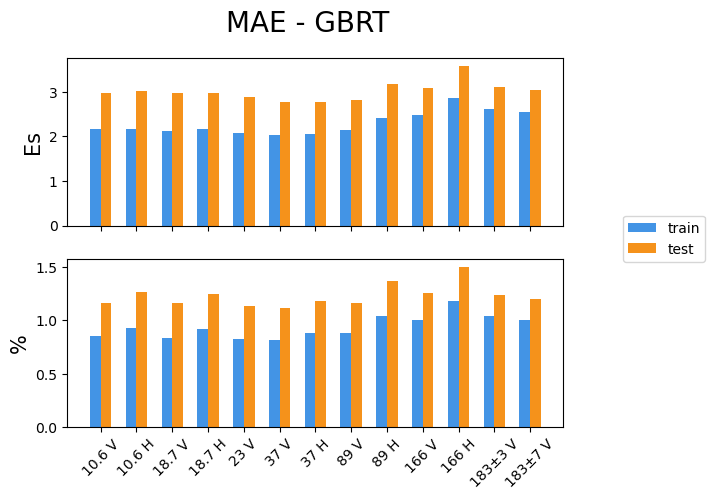

In [109]:
_x = np.array(list(range(labels.shape[1])))

plt.subplot(2, 1, 1)
plt.bar(_x-0.15, mae_train, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mae_test, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, [])
plt.ylabel('Es', fontsize=15)

plt.subplot(2, 1, 2)
plt.bar(_x-0.15, mape_train*100, width=0.3, color='#4394E5', label='train')
plt.bar(_x+0.15, mape_test*100, width=0.3, color='#F5921B', label='test')
plt.xticks(_x, channels[:len(_x)], rotation=45)
plt.ylabel('%', fontsize=15)

plt.legend(bbox_to_anchor=(1.3, 1.3))

plt.suptitle('MAE - GBRT', fontsize=20)

In [110]:
_gbrt_p_test = P_test

In [111]:
joblib.dump(gbrt_reg, 'gbrt_direct.jlb')

['gbrt_direct.jlb']

## Post analysis

/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mykhailo/micromamba/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


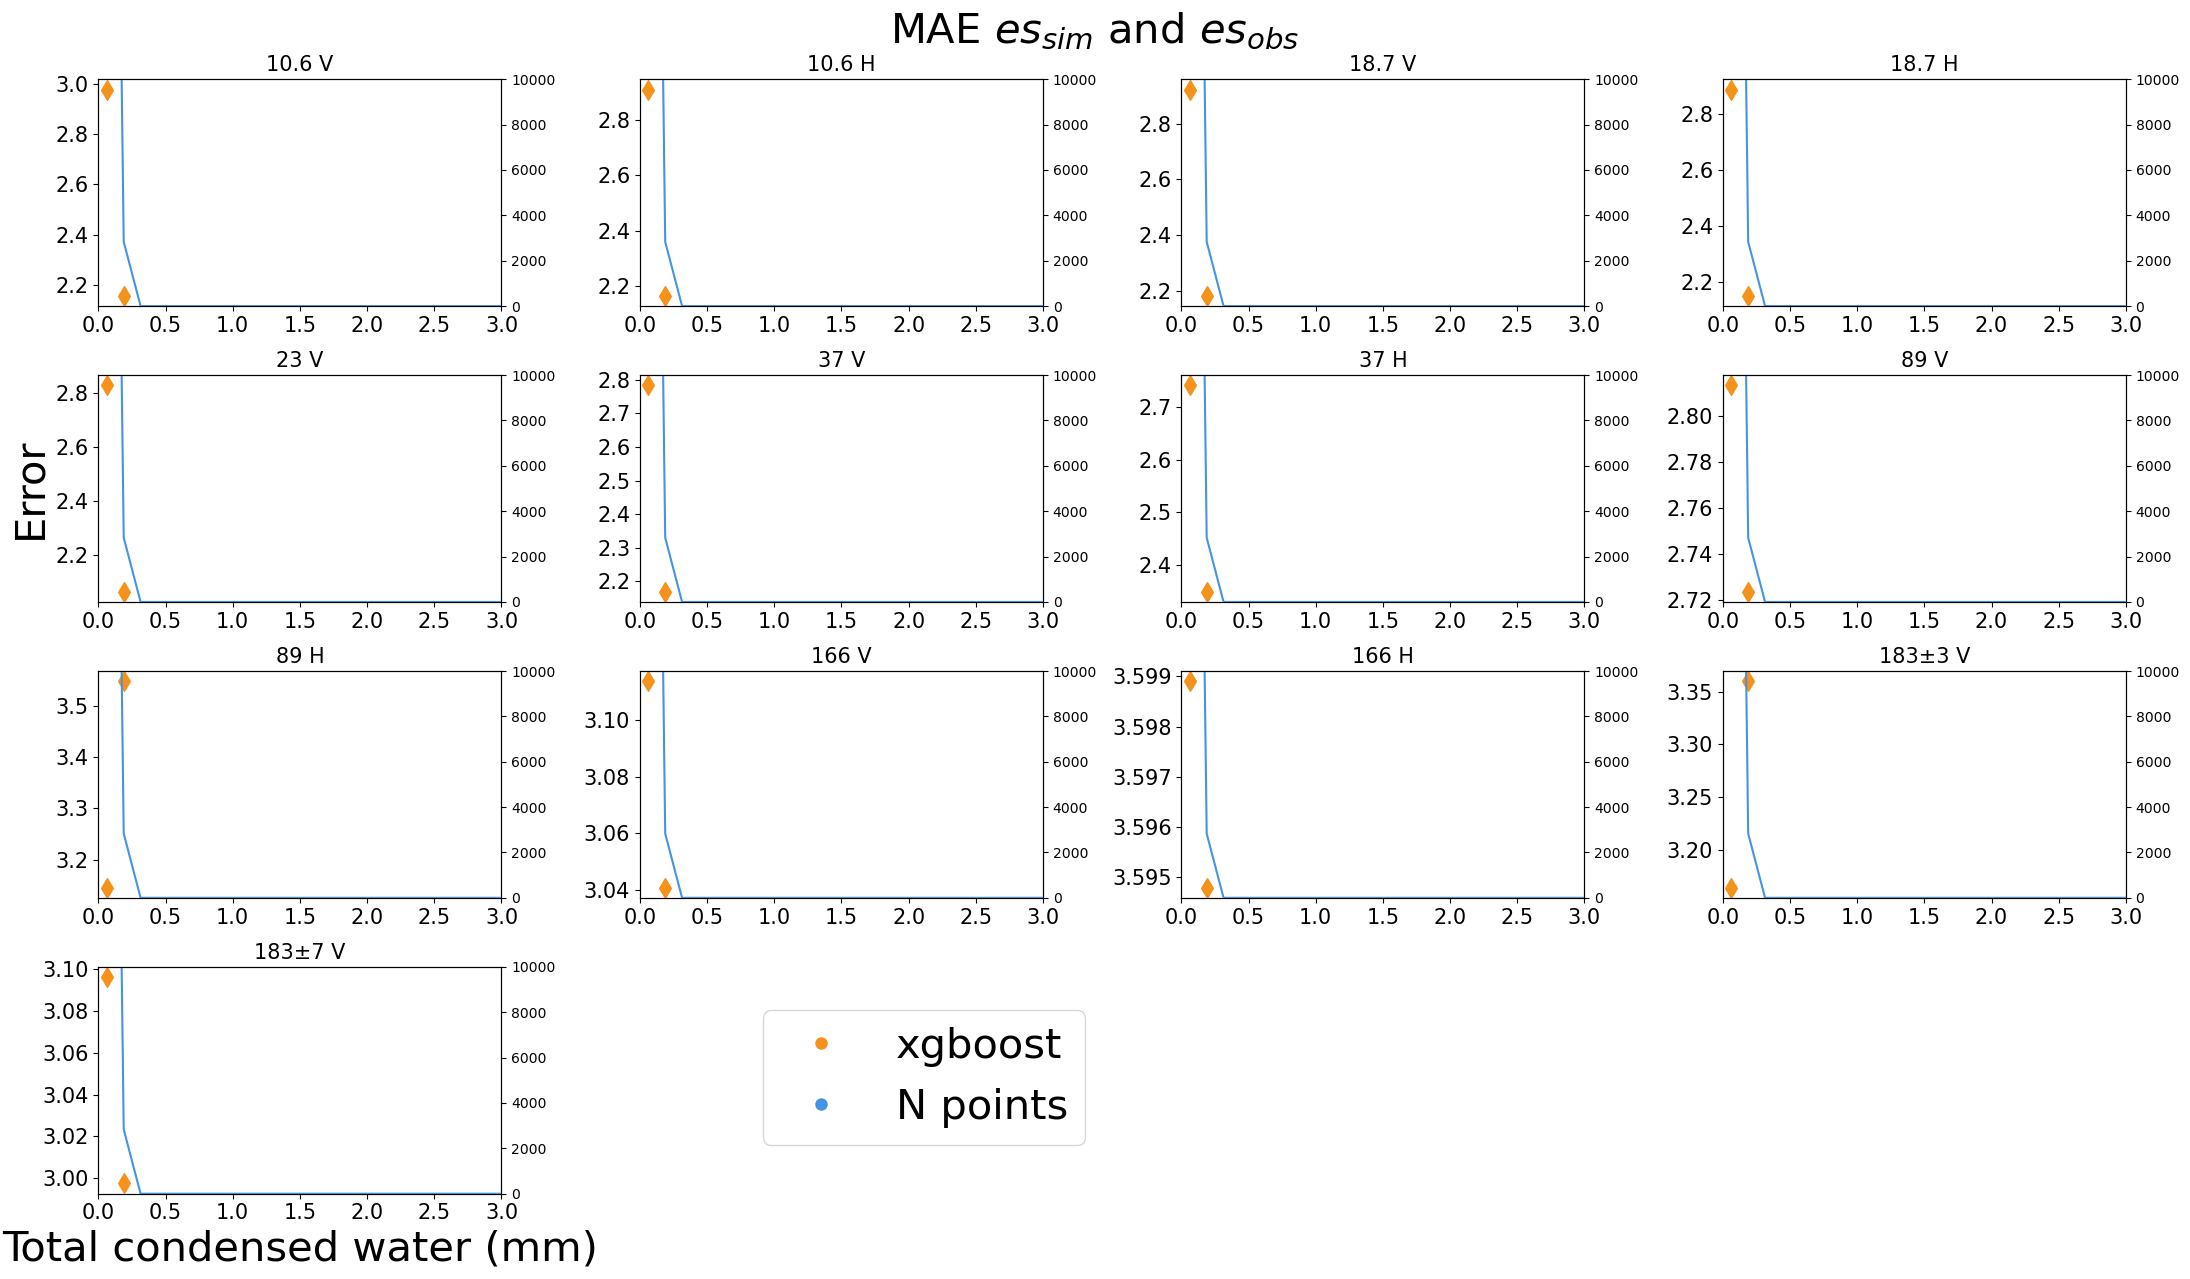

In [120]:
use_mask = land_mask | snow_mask | ice_mask

nbins = 100

bins = np.linspace(tcwv[use_mask].min(), tcwv[use_mask].max(), nbins+1)

error_xgboost = _xgb_p_test - Y_test

bin_indices = np.digitize(tcwv[use_data_mask&test_mask], bins) - 1

plt.figure(figsize=(22, 13))
for chan in range(13):
    plt.subplot(4, 4, chan+1)
    avg_errors_xgboost = []
    nsamples = []

    for i in range(nbins):
        bin_mask = bin_indices == i
        
        avg_errors_xgboost.append(np.mean(np.abs(error_xgboost[bin_mask,chan])))
        nsamples.append(len(error_xgboost[bin_mask,chan]))

    avg_errors_xgboost = np.array(avg_errors_xgboost)

    bin_centers = (bins[:-1] + bins[1:]) / 2

    plt.scatter(bin_centers, avg_errors_xgboost, c='#F5921B', marker='d', label='xgboost', s=100)

    if chan == 12:
        plt.xlabel('Total condensed water (mm)', fontsize=30)
    if chan == 4:
        plt.ylabel('Error', fontsize=30)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    plt.title(channels[chan], fontsize=15)
    plt.xlim(0, 3)
    # plt.ylim(0, 0.1)

    ax2 = plt.gca().twinx()
    ax2.plot(bin_centers, nsamples, c='#4394E5')
    ax2.set_ylim(0, 10000)

plt.suptitle('MAE $es_{sim}$ and $es_{obs}$', fontsize=30)
plt.tight_layout()

legend_handles = [
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F5921B', markersize=10, label='xgboost'),
    matplotlib.lines.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4394E5', markersize=10, label='N points'),
]
plt.legend(handles=legend_handles, bbox_to_anchor=(2.5, 0.9), fontsize=30)

In [122]:
lin_err = (metrics.mean_absolute_error(Y_test, _lin_p_test, multioutput='raw_values'))
grbt_err = (metrics.mean_absolute_error(Y_test, _gbrt_p_test, multioutput='raw_values'))
# nn_err = (metrics.mean_absolute_error(Y_test, _nn_p_test, multioutput='raw_values'))
xgb_err = (metrics.mean_absolute_error(Y_test, _xgb_p_test, multioutput='raw_values'))
nn_err = xgb_err

for i in range(len(channels)):
    print(f'{channels[i]:8s} {lin_err[i]:.3f} {grbt_err[i]:.3f} {nn_err[i]:.3f} {xgb_err[i]:.3f}')

10.6 V   3.315 2.972 2.941 2.941
10.6 H   3.194 3.014 2.878 2.878
18.7 V   3.390 2.973 2.889 2.889
18.7 H   3.368 2.973 2.856 2.856
23 V     3.602 2.880 2.795 2.795
37 V     3.213 2.775 2.756 2.756
37 H     3.278 2.767 2.724 2.724
89 V     3.249 2.824 2.809 2.809
89 H     3.663 3.168 3.164 3.164
166 V    3.499 3.085 3.110 3.110
166 H    4.242 3.591 3.599 3.599
183±3 V  3.318 3.118 3.173 3.173
183±7 V  3.597 3.039 3.092 3.092
